### Project 7 

In this project, you will implement the the clustering techniques that you've learned this week. 

#### Step 1: Load the python libraries that you will need for this project 

In [151]:
import pandas as pd 
import numpy as np
import random
from datetime import datetime
from IPython.core.display import Image, HTML

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline 
matplotlib.style.use('ggplot') 

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from __future__ import print_function, division

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import fcluster

In [5]:
print("Goal: Build a model that can accurately predict the sentiment of a tweet.")

print("How To: Use Truncated SVD with K-Means clustering")

Goal: Build a model that can accurately predict the sentiment of a tweet.
How To: Use Truncated SVD with K-Means clustering


# Create DataFrame and Display Info #


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55783 entries, 0 to 55782
Data columns (total 27 columns):
_unit_id                  55783 non-null int64
_created_at               55783 non-null object
_golden                   55783 non-null bool
_id                       55783 non-null int64
_missed                   1859 non-null object
_started_at               55783 non-null object
_tainted                  55783 non-null bool
_channel                  55783 non-null object
_trust                    55783 non-null float64
_worker_id                55783 non-null int64
_country                  55587 non-null object
_region                   46649 non-null object
_city                     46509 non-null object
_ip                       55783 non-null object
airline_sentiment         55783 non-null object
negativereason            36285 non-null object
airline                   55783 non-null object
airline_sentiment_gold    11997 non-null object
name                      55783 no

AttributeError: 'AxesSubplot' object has no attribute 'show'

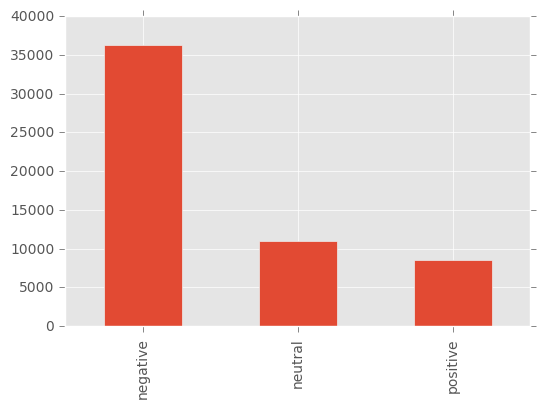

In [43]:
# Create DataFrame and get info
df = pd.read_csv("./../assets/tweets.csv")

# Display Info
info = df.info()
describe = df.describe
types = df.dtypes
shape = df.shape
head = df.head()
columns = list(df.columns.values)
df.columns.names = ['Columns']
df.index.names = ['Indexes']
vc_airline_sentiment = df['airline_sentiment'].value_counts()
vc_negativereason = df['negativereason'].value_counts()
# Percent of Total
vc_airline_sentiment_pot = df.groupby('airline_sentiment').size() * 100 / len(df)
vc_negativereason_pot = df.groupby('negativereason').size() * 100 / len(df)
listy_airlines = df['airline'].unique()
vc_airline_sentiment_bar_graph = vc_airline_sentiment.plot(kind='bar')
vc_negativereason_bar_graph = vc_negativereason.plot(kind='bar')


print(vc_airline_sentiment)
print(vc_negativereason)
print(listy_airlines)
head

# Clean The Data #

In [44]:
# Percent of column that is null
df.isnull().apply(lambda x: x/len(df), axis=0).sum()

Columns
_unit_id                  0.000000
_created_at               0.000000
_golden                   0.000000
_id                       0.000000
_missed                   0.966674
_started_at               0.000000
_tainted                  0.000000
_channel                  0.000000
_trust                    0.000000
_worker_id                0.000000
_country                  0.003514
_region                   0.163742
_city                     0.166251
_ip                       0.000000
airline_sentiment         0.000000
negativereason            0.349533
airline                   0.000000
airline_sentiment_gold    0.784934
name                      0.000000
negativereason_gold       0.828120
retweet_count             0.000000
text                      0.000000
tweet_coord               0.929997
tweet_created             0.000000
tweet_id                  0.000000
tweet_location            0.334098
user_timezone             0.323306
dtype: float64

In [45]:
#Drop columns with a lot of nan's
df = df.dropna(axis=1,thresh=(.75*len(df)))
# Remove the @airline bit of the text of the tweet
df['text'] = df['text'].str.replace('^@\\w+ *',"")
# Make tweet_created date/time
df['_started_at'] =  pd.to_datetime(df['_started_at'])


df.info()

/Users/Madballa55/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55783 entries, 0 to 55782
Data columns (total 20 columns):
_unit_id             55783 non-null int64
_created_at          55783 non-null object
_golden              55783 non-null bool
_id                  55783 non-null int64
_started_at          55783 non-null datetime64[ns]
_tainted             55783 non-null bool
_channel             55783 non-null object
_trust               55783 non-null float64
_worker_id           55783 non-null int64
_country             55587 non-null object
_region              46649 non-null object
_city                46509 non-null object
_ip                  55783 non-null object
airline_sentiment    55783 non-null object
airline              55783 non-null object
name                 55783 non-null object
retweet_count        55783 non-null int64
text                 55783 non-null object
tweet_created        55783 non-null object
tweet_id             55783 non-null int64
dtypes: bool(2), datetime64[ns]

/Users/Madballa55/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
# Export to CSV for tableau
df.to_csv('./../assets/tweets_cleaned.csv', sep=',', encoding='utf-8')

# TfidfVectorizer (to find most important words) #

In [121]:
# Positive Words
x_pos = df.ix[df.airline_sentiment == 'positive', 'text']
y_pos = df.ix[df.airline_sentiment == 'positive', 'airline_sentiment']

In [122]:
# Negative Words
x_neg = df.ix[df.airline_sentiment == 'negative', 'text']
y_neg  = df.ix[df.airline_sentiment == 'negative', 'airline_sentiment']

In [143]:
# MODEL

def vectorizer(x):
    # Create vectorizer of words
    v = TfidfVectorizer(stop_words=['english','didn','this','your','http','were','that','they','with','been','what','guys'],
                        token_pattern='[A-Za-z]{4,50}', 
                        ngram_range=(1, 1),
                        max_features = 20,
                        min_df = 2,
                        max_df = .5,
                        )
    # Fit Vectorizer
    vec = v.fit(x)
    x = vec.transform(x).todense()
    # Visualize the vectorizer (Rows are newsgroups, columns are earch word)
    df_x = pd.DataFrame(x, columns = list(v.vocabulary_))

    return df_x.sum(axis=0).sort_values(ascending=False)



In [128]:
print('Positive Words')
top_pos_words = vectorizer(x_pos)
top_pos_words[0:20]

Positive Words


wonderful    1400.323949
flying       1346.325898
thank         826.042285
great         482.688580
just          447.585167
have          402.365703
service       386.849912
reps          366.355199
best          340.757510
finally       327.886151
from          326.234633
customer      321.292609
ones          307.886648
good          288.571089
flight        279.285045
awesome       231.088887
love          208.604899
will          195.041590
thanks        164.825892
dallas        150.837191
dtype: float64

In [129]:
print('Negative Words')
top_neg_words = vectorizer(x_neg)
top_neg_words[0:20]

Negative Words


hours       5595.619632
after       3126.464553
plane       1938.241361
need        1901.773799
call        1884.617862
gate        1865.794145
delayed     1817.955492
just        1771.817039
service     1681.384061
still       1673.782032
flight      1466.712516
time        1418.499397
customer    1321.440322
hold        1301.563577
would       1253.347173
from        1246.959265
over        1241.074098
hour        1209.436744
help        1156.480730
have        1149.663902
dtype: float64

# Truncated SVD (to reduce # of features/words) #

In [116]:
def tsvd(x):

    # Initialize Model
    SVD = TruncatedSVD(n_components = 14, random_state=42)
    # Fit Transform
    SVD.fit_transform(x)
    
    df_reduced_words = pd.DataFrame(SVD.components_.T, index = p_vec.get_feature_names())
    df_reduced_words = df_reduced_words.transpose()
    
    return df_reduced_words

In [134]:
tsvd(x_pos)

ValueError: could not convert string to float: thank you we got on a different flight to Chicago.

# Use Kmeans to Create Positive/Negative Predictions #  

In [152]:
v = TfidfVectorizer(stop_words=['english','didn','this','your','http','were','that','they','with','been','what','guys'],
                        token_pattern='[A-Za-z]{4,50}', 
                        ngram_range=(1, 1),
                        max_features = 20,
                        min_df = 2,
                        max_df = .5,
                        )

X = v.fit_transform(df['text'])
model_kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=100, n_init=30)
model_kmeans.fit(X)
labels = pd.DataFrame(model_kmeans.labels_)

y_pred = np.choose(labels, [0,1])

le = LabelEncoder()
y = le.fit_transform(df['airline_sentiment'])

# Measure Accuracy #

In [155]:
print(classification_report(y, y_pred))

             precision    recall  f1-score   support

          0       0.63      0.79      0.70     36280
          1       0.15      0.14      0.14     11027
          2       0.00      0.00      0.00      8476

avg / total       0.44      0.54      0.49     55783

